**Group Project**

## Getting the Data

https://www.kaggle.com/datasets/davidcariboo/player-scores

## Merging the Data

In [167]:
import pandas as pd
import numpy as np
import sklearn

In [168]:
directory='/Users/adityodasgupta/Documents/McGill/Fatih/Football_Transfermarkt/Data/'

In [169]:
# Reading CSV files into dataframes
appearances = pd.read_csv(directory+'appearances.csv')
club_games = pd.read_csv(directory+'club_games.csv')
clubs = pd.read_csv(directory+'clubs.csv')
competitions = pd.read_csv(directory+'competitions.csv')
game_events = pd.read_csv(directory+'game_events.csv')
games = pd.read_csv(directory+'games.csv')
player_valuations = pd.read_csv(directory+'player_valuations.csv')
players = pd.read_csv(directory+'players.csv')

In [170]:
# Yearly Player Game Stats
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year
player_games_stats = appearances.\
    groupby(['player_id', 'year']).\
    agg(avg_game_dur = ('minutes_played', 'mean'),
        avg_games_played = ('appearance_id', 'count'),
        avg_yellow_cards = ('yellow_cards', 'mean'),
        avg_red_cards = ('red_cards', 'mean'),
        avg_goals = ('goals', 'mean'),
        avg_assists = ('assists', 'mean'),
        avg_minutes_played = ('minutes_played', 'mean')).\
    reset_index()
player_games_stats.head(1)

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played
0,10,2014.00000,33.06667,15,0.13333,0.00000,0.26667,0.20000,33.06667


In [171]:
# Yearly Player Games Played (away & home)
player_games_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(games_played = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='games_played').\
    reset_index().\
    rename(columns={'Away': 'games_played_away', 'Home': 'games_played_home'})
player_games_home_away.head(1)

hosting,player_id,year,games_played_away,games_played_home
0,10,2014.00000,7.00000,8.00000


In [172]:
# Yearly Player Win Percentage (away & home)
player_win_perc_home_away = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year', 'hosting']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='hosting', values='win_perc').\
    reset_index().\
    rename(columns={'Away': 'away_win_percentage', 'Home': 'home_win_percentage'})
player_win_perc_home_away.head(1)

hosting,player_id,year,away_win_percentage,home_win_percentage
0,10,2014.00000,0.28571,0.75000


In [173]:
# Yearly Player Win Percentage (total)
player_win_perc = appearances[['player_id', 'game_id', 'player_club_id', 'year']].\
    rename(columns={'player_club_id':'club_id'}).\
    merge(club_games, on=['club_id', 'game_id'], how='left').\
    groupby(['player_id', 'year']).\
    agg(win_perc = ('is_win', 'mean')).\
    reset_index()
player_win_perc.head(1)

,player_id,year,win_perc
0,10,2014.00000,0.53333


In [174]:
# Yearly Games Played by Competition Type
player_comp_types = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year', 'competition_type']).\
    agg(competitions_attended = ('game_id', 'count')).\
    reset_index().\
    pivot(index=['player_id','year'], columns='competition_type', values='competitions_attended').\
    reset_index().\
    fillna({'domestic_cup':0, 'domestic_league':0, 'international_cup':0, 'other':0}).\
    rename(columns={'domestic_cup': 'games_player_domestic_cup', 'domestic_league': 'games_played_domestic_league',
            'international_cup': 'games_player_international_cup', 'other': 'games_played_other'})
player_comp_types.head(1)

competition_type,player_id,year,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other
0,10,2014.00000,1.00000,14.00000,0.00000,0.00000


In [175]:
# Player Popularity
player_pop = appearances[['player_id', 'game_id', 'year']].\
    merge(games, on='game_id', how='left').\
    groupby(['player_id', 'year']).\
    agg(player_avg_game_attendance = ('attendance', 'mean')).\
    reset_index()
player_pop.head(1)

,player_id,year,player_avg_game_attendance
0,10,2014.00000,25929.26667


In [176]:
# Player Stats
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['year_of_birth'] = players['date_of_birth'].dt.year
player_relevant_stats = players[['player_id', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm', 'year_of_birth']]
player_relevant_stats.head(1)

,player_id,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth
0,134354,Belgium,Belgium,Aalst,Attack,Centre-Forward,Right,0,1995.00000


In [177]:
# Player Valuation (Mnay NA Values because it is tracked much earlier than stats)
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year
player_yearly_val =player_valuations.\
    groupby(['player_id', 'year']).\
    agg(mean_market_value_in_eur = ('market_value_in_eur', 'mean'),
        max_market_value_in_eur = ('market_value_in_eur', 'max')).\
    reset_index()

In [178]:
# Final Aggregation
data = player_games_stats.\
    merge(player_games_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc_home_away, on=['player_id', 'year'], how='outer').\
    merge(player_win_perc, on=['player_id', 'year'], how='outer').\
    merge(player_comp_types, on=['player_id', 'year'], how='outer').\
    merge(player_pop, on=['player_id', 'year'], how='outer').\
    merge(player_yearly_val, on=['player_id', 'year'], how='outer').\
    merge(player_relevant_stats, on=['player_id'], how='left')
data['age'] = data['year'] - data['year_of_birth']
data.columns

Index(['player_id', 'year', 'avg_game_dur', 'avg_games_played',
       'avg_yellow_cards', 'avg_red_cards', 'avg_goals', 'avg_assists',
       'avg_minutes_played', 'games_played_away', 'games_played_home',
       'away_win_percentage', 'home_win_percentage', 'win_perc',
       'games_player_domestic_cup', 'games_played_domestic_league',
       'games_player_international_cup', 'games_played_other',
       'player_avg_game_attendance', 'mean_market_value_in_eur',
       'max_market_value_in_eur', 'country_of_citizenship', 'country_of_birth',
       'city_of_birth', 'position', 'sub_position', 'foot', 'height_in_cm',
       'year_of_birth', 'age'],
      dtype='object')

In [179]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,max_market_value_in_eur,country_of_citizenship,country_of_birth,city_of_birth,position,sub_position,foot,height_in_cm,year_of_birth,age
0,10,2014.00000,33.06667,15.00000,0.13333,0.00000,0.26667,0.20000,33.06667,7.00000,...,1000000.00000,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.00000,1978.00000,36.00000
1,10,2015.00000,67.47222,36.00000,0.16667,0.00000,0.33333,0.22222,67.47222,17.00000,...,1000000.00000,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.00000,1978.00000,37.00000
2,10,2016.00000,53.90000,20.00000,0.05000,0.00000,0.40000,0.25000,53.90000,7.00000,...,1000000.00000,Germany,Poland,Opole,Attack,Centre-Forward,Right,184.00000,1978.00000,38.00000
3,26,2014.00000,90.00000,17.00000,0.00000,0.00000,0.00000,0.00000,90.00000,10.00000,...,5000000.00000,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.00000,1980.00000,34.00000
4,26,2015.00000,90.00000,24.00000,0.00000,0.00000,0.00000,0.00000,90.00000,11.00000,...,3000000.00000,Germany,Germany,Diez,Goalkeeper,NaN,Left,190.00000,1980.00000,35.00000


## Feature Engineering

In [180]:
from countryinfo import countries

In [181]:
country=[]
continent=[]
for i in countries :
    country.append(i['name'])
    continent.append(i['continent'])

In [182]:
mapping=pd.DataFrame({'country_of_citizenship':country,'continent':continent})

In [183]:
data=data.merge(mapping, on='country_of_citizenship', how='left')

In [184]:
data.drop(columns=['country_of_citizenship','country_of_birth','city_of_birth'],inplace=True)

In [185]:
# For Imputation (Filling some null values with 0)
data = data.query('avg_games_played > 0')
#data = data.dropna(subset=['win_perc', 'mean_market_value_in_eur'])
data = data.fillna({'games_played_away': 0, 
                    'games_played_home': 0, 
                    'games_player_domestic_cup': 0, 
                    'games_played_domestic_league': 0, 
                    'games_player_international_cup': 0, 
                    'games_played_other': 0,
                    'away_win_percentage' : 0,
                    'home_win_percentage' : 0})

for col in data.columns:
    null_rows_idx = data[[col]].isnull().any(axis=1)
    if len(data[null_rows_idx]) > 0:
        print(col, data[null_rows_idx].shape)
# Output shows us which columns still have null values which we will fix/impute later in Data Cleaning

data.to_csv('data_merged.csv')

win_perc (122, 28)
mean_market_value_in_eur (2167, 28)
max_market_value_in_eur (2167, 28)
position (32, 28)
sub_position (5596, 28)
foot (1281, 28)
height_in_cm (32, 28)
year_of_birth (53, 28)
age (53, 28)
continent (11174, 28)


In [186]:
data.year_of_birth=data.year_of_birth.astype('str')

In [187]:
data['contribution_per_game']=data['avg_goals']+data['avg_assists']

## Analyzing the Data Structure

In [188]:
data.head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
0,10,2014.00000,33.06667,15.00000,0.13333,0.00000,0.26667,0.20000,33.06667,7.00000,...,1000000.00000,1000000.00000,Attack,Centre-Forward,Right,184.00000,1978.0,36.00000,Europe,0.46667
1,10,2015.00000,67.47222,36.00000,0.16667,0.00000,0.33333,0.22222,67.47222,17.00000,...,1000000.00000,1000000.00000,Attack,Centre-Forward,Right,184.00000,1978.0,37.00000,Europe,0.55556
2,10,2016.00000,53.90000,20.00000,0.05000,0.00000,0.40000,0.25000,53.90000,7.00000,...,1000000.00000,1000000.00000,Attack,Centre-Forward,Right,184.00000,1978.0,38.00000,Europe,0.65000
3,26,2014.00000,90.00000,17.00000,0.00000,0.00000,0.00000,0.00000,90.00000,10.00000,...,5000000.00000,5000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,34.00000,Europe,0.00000
4,26,2015.00000,90.00000,24.00000,0.00000,0.00000,0.00000,0.00000,90.00000,11.00000,...,2000000.00000,3000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,35.00000,Europe,0.00000


In [189]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64924 entries, 0 to 64923
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   player_id                       64924 non-null  int64  
 1   year                            64924 non-null  float64
 2   avg_game_dur                    64924 non-null  float64
 3   avg_games_played                64924 non-null  float64
 4   avg_yellow_cards                64924 non-null  float64
 5   avg_red_cards                   64924 non-null  float64
 6   avg_goals                       64924 non-null  float64
 7   avg_assists                     64924 non-null  float64
 8   avg_minutes_played              64924 non-null  float64
 9   games_played_away               64924 non-null  float64
 10  games_played_home               64924 non-null  float64
 11  away_win_percentage             64924 non-null  float64
 12  home_win_percentage             

In [190]:
data.describe()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,games_player_domestic_cup,games_played_domestic_league,games_player_international_cup,games_played_other,player_avg_game_attendance,mean_market_value_in_eur,max_market_value_in_eur,height_in_cm,age,contribution_per_game
count,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,...,64924.00000,64924.00000,64924.00000,64924.00000,64924.00000,62757.00000,62757.00000,64892.00000,64871.00000,64924.00000
mean,201168.04196,2017.93369,63.65187,15.98296,0.14059,0.00381,0.07413,0.05694,63.65187,8.02333,...,1.04692,13.72342,1.16666,0.04598,14400.01044,3874548.76309,4394322.78471,180.09779,25.90523,0.13107
std,161988.73646,2.46591,24.15819,11.63799,0.15506,0.02546,0.13111,0.09583,24.15819,5.93219,...,1.37836,10.00117,2.54685,0.25488,12958.27855,8994894.37480,9949812.01517,20.48394,4.53557,0.18231
min,10.00000,2014.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,10000.00000,10000.00000,0.00000,15.00000,0.00000
25%,64992.00000,2016.00000,48.10259,6.00000,0.00000,0.00000,0.00000,0.00000,48.10259,3.00000,...,0.00000,5.00000,0.00000,0.00000,4345.42424,400000.00000,450000.00000,177.00000,22.00000,0.00000
50%,164912.50000,2018.00000,69.88235,14.00000,0.11111,0.00000,0.00000,0.00000,69.88235,7.00000,...,1.00000,13.00000,0.00000,0.00000,10650.52500,1000000.00000,1000000.00000,182.00000,26.00000,0.06667
75%,292357.00000,2020.00000,84.11111,24.00000,0.21429,0.00000,0.10345,0.09091,84.11111,12.00000,...,2.00000,20.00000,0.00000,0.00000,20633.82500,3166666.66667,3600000.00000,187.00000,29.00000,0.20000
max,987700.00000,2022.00000,120.00000,59.00000,2.00000,1.00000,3.00000,2.00000,120.00000,31.00000,...,11.00000,44.00000,19.00000,5.00000,83439.00000,200000000.00000,200000000.00000,206.00000,44.00000,3.00000


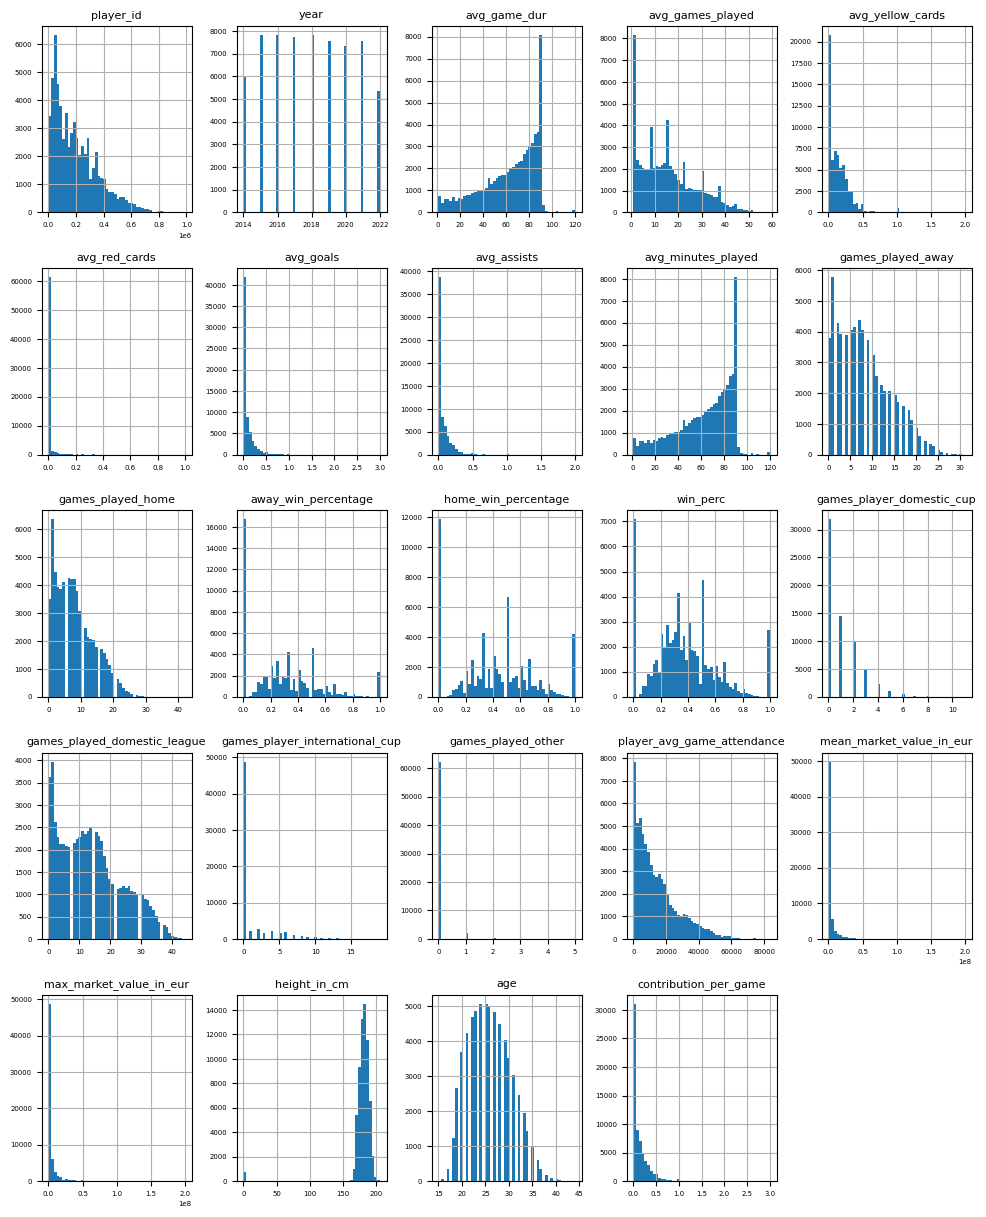

In [191]:
import matplotlib.pyplot as plt

plt.rc('font', size = 5)
plt.rc('axes', labelsize = 5, titlesize = 8)
plt.rc('legend', fontsize = 5)
plt.rc('xtick', labelsize = 5)
plt.rc('ytick', labelsize = 5)

data.hist(bins = 50, figsize = (12, 15))
plt.show()

Many variables are skewed to the left/right, meaning that they extend on the left/right of the median. This can make it difficult for our model to identify patterns. Later, we will transform these attributes to have normal distributions.

# Preparing the Data for Machine Learning Algorithms

## Data Cleaning

In [192]:
null_rows_idx = data.isnull().any(axis=1)
data.loc[null_rows_idx].head()

,player_id,year,avg_game_dur,avg_games_played,avg_yellow_cards,avg_red_cards,avg_goals,avg_assists,avg_minutes_played,games_played_away,...,mean_market_value_in_eur,max_market_value_in_eur,position,sub_position,foot,height_in_cm,year_of_birth,age,continent,contribution_per_game
3,26,2014.00000,90.00000,17.00000,0.00000,0.00000,0.00000,0.00000,90.00000,10.00000,...,5000000.00000,5000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,34.00000,Europe,0.00000
4,26,2015.00000,90.00000,24.00000,0.00000,0.00000,0.00000,0.00000,90.00000,11.00000,...,2000000.00000,3000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,35.00000,Europe,0.00000
5,26,2016.00000,92.00000,15.00000,0.06667,0.00000,0.00000,0.00000,92.00000,9.00000,...,1000000.00000,1000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,36.00000,Europe,0.00000
6,26,2017.00000,60.33333,3.00000,0.00000,0.00000,0.00000,0.00000,60.33333,1.00000,...,916666.66667,1000000.00000,Goalkeeper,NaN,Left,190.00000,1980.0,37.00000,Europe,0.00000
7,26,2018.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,...,NaN,NaN,Goalkeeper,NaN,Left,190.00000,1980.0,38.00000,Europe,0.00000


In [193]:
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 17932 rows with null values in the dataset.


## Advanced Imputation

In [194]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

num_cols = ['win_perc','age','height_in_cm','mean_market_value_in_eur','max_market_value_in_eur']
imputer = IterativeImputer()
imputed = imputer.fit_transform(data[num_cols])
data.loc[:, num_cols] = imputed

In [195]:
from sklearn.impute import SimpleImputer

# create an imputer that uses the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

cat_cols=['continent','year_of_birth','foot','position']

# fit the imputer on the data frame
imputer.fit(data[cat_cols])

# transform the data frame
data[cat_cols] = imputer.transform(data[cat_cols])

In [196]:
# Filling in missing sub_position values

# Grouping sub_position by position
sub_positions_by_position = data.groupby('position')['sub_position'].apply(list)

# Finding the most frequent sub_position for each position
sub_positions_count_by_position = sub_positions_by_position.apply(lambda x: pd.Series(x).value_counts()).fillna(0).astype(int)
sub_positions_count_by_position_dict = sub_positions_count_by_position.to_dict()

# Finding the most frequent sub_position for each position
most_frequent_sub_positions_by_position = sub_positions_count_by_position.idxmax(axis=1)

# Creating a new DataFrame with position and most frequent sub_position columns
df = pd.DataFrame({'position': most_frequent_sub_positions_by_position.index,
                   'most_frequent_sub_position': most_frequent_sub_positions_by_position.values})

df

,position,most_frequent_sub_position
0,Attack,Centre-Forward
1,Defender,Centre-Back
2,Goalkeeper,Centre-Forward
3,Midfield,Central Midfield


In [197]:
df_merged = df.merge(sub_positions_count_by_position, left_on='position', right_index=True)
most_frequent_sub_positions_dict = df_merged.set_index('position')['most_frequent_sub_position'].to_dict()

# Replace sub_position null values with most frequent sub_positions for their corresponding positions
data['sub_position'] = data.apply(lambda row: most_frequent_sub_positions_dict[row['position']] if pd.isnull(row['sub_position']) else row['sub_position'], axis=1)

In [198]:
# Just to be sure that all worked, count the number of null values in the sub_position column
num_null_values = data['sub_position'].isnull().sum()

print(f"There are {num_null_values} null values in the sub_position column")

There are 0 null values in the sub_position column


In [199]:
# Just to make sure eveyrthing worked
null_counts = data.isnull().sum(axis=1)
num_null_rows = (null_counts > 0).sum()

print(f'There are {num_null_rows} rows with null values in the dataset.')

There are 0 rows with null values in the dataset.


## Handling Text and Categorical Attributes

In [200]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

## Entity Embedding

In [201]:
cat_cols=['continent','position','sub_position']

for i in cat_cols:  
    
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

    # Define the number of categories and the embedding size
    num_categories = data[i].nunique()
    embedding_dim = data[i].nunique()//2

    # Create a tensor of categorical values
    categorical_column = torch.randint(low=0, high=num_categories, size=(len(data[i]),))

    # Create the embedding layer
    embedding_layer = nn.Embedding(num_embeddings=num_categories, embedding_dim=embedding_dim)

    # Apply the embedding layer to the categorical column
    embedded_column = embedding_layer(categorical_column)

    embedded_df = pd.DataFrame(embedded_column.detach().numpy(), columns=[i+f'_embed_{j}' for j in range(embedding_dim)])

    # Replace the original categorical column with the embedded DataFrame
    data = pd.concat([data.drop(i, axis=1), embedded_df], axis=1)

## One Hot Encoding

In [202]:
data = data.join(pd.get_dummies(data['foot'].mask(data['foot']=='left')))

In [205]:
data.drop(columns='Left',inplace=True)

## Data Leakage Analysis

Analyse how the performance changes between train, validation and test set - Rohana/Hai

Do post modelling

In [206]:
data.to_csv('CausalML Data.csv')

In [207]:
pip install causalml

  Using cached causalml-0.13.0-cp39-cp39-macosx_10_9_x86_64.whl
  Using cached pathos-0.2.9-py3-none-any.whl (76 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 6.0 MB/s eta 0:00:0000:0100:01
  Using cached pyro_ppl-1.8.4-py3-none-any.whl (730 kB)
  Using cached forestci-0.6-py3-none-any.whl (12 kB)
  Using cached pydotplus-2.0.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 14.4 MB/s eta 0:00:0000:0100:01
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
  Using cached pox-0.3.2-py3-none-any.whl (29 kB)
  Using cached ppft-1.7.6.6-py3-none-any.whl (52 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 13.7 MB/s eta 0:00:0000:0100:01
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 14.0 MB/s eta 0:00:0000:0100:01
  Using cached pyro_api-0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 13.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.38.0
    Uninstalling llvmlite-0.38.0:
      Successfully uninstalled llvmlite-0.38.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4
  Atte

In [211]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
#from causalml.dataset.regression import *
from causalml.metrics import *

import os, sys

%matplotlib inline

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

OSError: dlopen(/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'
  Referenced from: '/opt/anaconda3/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so'
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)